This assumes that you've used this notebook to convert your allocated CSVs to Parquet and the Parquet files reside at `/content/drive/MyDrive/project1/dataset_parquet`: https://colab.research.google.com/drive/1dk6aVSERUQzKt9keeM17RtIZRvfVbqpb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Project1") \
    .getOrCreate()

parquet_folder_path = "/content/drive/MyDrive/project1/dataset_parquet"

df = spark.read.parquet(parquet_folder_path)

df.head()

Row(Reference Pool ID=None, Loan Identifier=100007365142, Monthly Reporting Period=12000, Channel='R', Seller Name='Jpmorgan Chase Bank, Na', Servicer Name=None, Master Servicer=None, Original Interest Rate=8.0, Current Interest Rate=8.0, Original UPB=75000.0, UPB at Issuance=None, Current Actual UPB=0.0, Original Loan Term=360, Origination Date=121999, First Payment Date=22000, Loan Age=0, Remaining Months to Legal Maturity=360, Remaining Months To Maturity=359, Maturity Date=12030, Original Loan to Value Ratio (LTV)=79, Original Combined Loan to Value Ratio (CLTV)=None, Number of Borrowers=1, Debt-To-Income (DTI)=62, Borrower Credit Score at Origination=763, Co-Borrower Credit Score at Origination=None, First Time Home Buyer Indicator='N', Loan Purpose ='R', Property Type='SF', Number of Units=1, Occupancy Status='P', Property State='PA', Metropolitan Statistical Area (MSA)=0, Zip Code Short=173, Mortgage Insurance Percentage=None, Amortization Type='FRM', Prepayment Penalty Indicato

Repartition the dataframe to get better parallelism.

In [ ]:
df = df.repartition(4)

Let's project the columns that we need for analysis

In [ ]:
from pyspark.sql.functions import col

# Columns to select
columns_to_select = [
    "Origination Date",
    "Borrower Credit Score at Origination",
    "Co-Borrower Credit Score at Origination",
    "Monthly Reporting Period",
    "Current Loan Delinquency Status",
    "Original Loan Term",
    "First Time Home Buyer Indicator",
    "Zero Balance Code",
    "Original Loan to Value Ratio (LTV)",
    "Original Interest Rate",
    "Net Sales Proceeds",
    "Credit Enhancement Proceeds",
    "Repurchase Make Whole Proceeds",
    "Other Foreclosure Proceeds",
    "UPB at the Time of Removal",
    "Property State",
    "Original UPB"
]

df_selected = df.select([col(c) for c in columns_to_select])
df_selected.head()

Row(Origination Date=121999, Borrower Credit Score at Origination=693, Co-Borrower Credit Score at Origination=575, Monthly Reporting Period=52008, Current Loan Delinquency Status='00', Original Loan Term=180, First Time Home Buyer Indicator='N', Zero Balance Code=None, Original Loan to Value Ratio (LTV)=72, Original Interest Rate=8.375, Net Sales Proceeds=None, Credit Enhancement Proceeds=None, Repurchase Make Whole Proceeds=None, Other Foreclosure Proceeds=None, UPB at the Time of Removal=None, Property State='ME', Original UPB=50000.0)

Analysis 1: I'm going to use `Origination Date` (MMYYYY) as the date column and then both `Borrower Credit Score at Origination` and `Co-Borrower Credit Score at Origination` columns

In [ ]:
from pyspark.sql.functions import col, substring, avg

df_fico = df_selected.select(
    col("Origination Date").alias("origination_date"),
    col("Borrower Credit Score at Origination").cast("integer").alias("borrower_fico"),
    col("Co-Borrower Credit Score at Origination").cast("integer").alias("co_borrower_fico")
)

df_fico = df_fico.withColumn("year", substring("origination_date", -4, 4).cast("integer"))

average_fico = df_fico.groupBy("year").agg(
    avg("borrower_fico").alias("avg_borrower_fico"),
    avg("co_borrower_fico").alias("avg_co_borrower_fico")
)

average_fico.show()

+----+-----------------+--------------------+
|year|avg_borrower_fico|avg_co_borrower_fico|
+----+-----------------+--------------------+
|2000|709.3637166016634|   716.8880193109371|
|1999|710.8358871682035|    718.146959514069|
+----+-----------------+--------------------+



Analysis 2:

Let's convert this into 2 problems:
a. The monthly delinquency rates for 30, 60 and 90 days past due
b. how they vary by loan term

Analysis 2a:

It's a simple bucketing, group by, and join problem.

`Monthly Reporting Period` is in format MMYYYY and `Current Loan Delinquency Status` contains number of months since delinquecy.

In [ ]:
from pyspark.sql.functions import col, substring, count, length, when, expr

df_delin = (
    df_selected
    .withColumn("period_len", length(col("Monthly Reporting Period")))
    .withColumn(
        "month_str",
        expr("substring(`Monthly Reporting Period`, 1, period_len - 4)")
    )
    .withColumn("month", col("month_str").cast("int"))
    .withColumn("year", substring(col("Monthly Reporting Period"), -4, 4).cast("int"))
    .drop("period_len", "month_str")
)

df_delin = df_delin.withColumn(
    "delinquency_category",
    when((col("Current Loan Delinquency Status") >= 30) & (col("Current Loan Delinquency Status") < 60), "30 Days")
    .when((col("Current Loan Delinquency Status") >= 60) & (col("Current Loan Delinquency Status") < 90), "60 Days")
    .when((col("Current Loan Delinquency Status") >= 90) & (col("Current Loan Delinquency Status") < 120), "90 Days")
    .otherwise("Other")
)

total_loans_df = df_delin.groupBy("year", "month").agg(count("*").alias("total_loans"))

delinquency_df = df_delin.groupBy("year", "month", "delinquency_category").agg(count("*").alias("delinquent_count"))

result = delinquency_df.join(total_loans_df, ["year", "month"]) \
    .withColumn("delinquency_rate", col("delinquent_count") / col("total_loans") * 100)

result_filtered = result.filter(col("delinquency_category").isin("30 Days", "60 Days", "90 Days"))

pandas_df_delin = result_filtered.orderBy("year", "month", "delinquency_category").toPandas()

pandas_df_delin

,year,month,delinquency_category,delinquent_count,total_loans,delinquency_rate
0,2002,8,30 Days,1,113782,0.000879
1,2002,9,30 Days,1,108203,0.000924
2,2002,10,30 Days,1,101954,0.000981
3,2002,11,30 Days,3,95020,0.003157
4,2002,12,30 Days,2,88943,0.002249
...,...,...,...,...,...,...
604,2024,7,90 Days,1,899,0.111235
605,2024,8,60 Days,1,891,0.112233
606,2024,8,90 Days,1,891,0.112233
607,2024,9,60 Days,1,883,0.113250


Analysis 2b: Same as 2a but instead of looking at it month/year wise, we need to look at it by `Original Loan Term`. `Original Loan Term` is in months. It's a common practice to convert loan terms into yearly buckets. I'll convert them into:

Under 10 years

10–14 years

15–19 years

20–24 years

25–29 years

30 years

In [ ]:
from pyspark.sql.functions import col, count, when

df_bucketed = df_selected.withColumn(
    "loan_term_bucket",
    when(col("Original Loan Term") < 120, "Under 10 years")
    .when((col("Original Loan Term") >= 120) & (col("Original Loan Term") < 180), "10-14 years")
    .when((col("Original Loan Term") >= 180) & (col("Original Loan Term") < 240), "15-19 years")
    .when((col("Original Loan Term") >= 240) & (col("Original Loan Term") < 300), "20-24 years")
    .when((col("Original Loan Term") >= 300) & (col("Original Loan Term") < 360), "25-29 years")
    .when(col("Original Loan Term") == 360, "30 years")
    .otherwise("Other")
)

df_bucketed = df_bucketed.withColumn(
    "delinquency_category",
    when((col("Current Loan Delinquency Status") >= 30) & (col("Current Loan Delinquency Status") < 60), "30 Days")
    .when((col("Current Loan Delinquency Status") >= 60) & (col("Current Loan Delinquency Status") < 90), "60 Days")
    .when((col("Current Loan Delinquency Status") >= 90) & (col("Current Loan Delinquency Status") < 120), "90 Days")
    .otherwise("Other")
)

total_loans_df = df_bucketed.groupBy("loan_term_bucket").agg(count("*").alias("total_loans"))

delinquency_df = df_bucketed.groupBy("loan_term_bucket", "delinquency_category").agg(count("*").alias("delinquent_count"))

result = delinquency_df.join(total_loans_df, ["loan_term_bucket"]).withColumn(
    "delinquency_rate", col("delinquent_count") / col("total_loans") * 100
)

result_filtered = result.filter(col("delinquency_category").isin("30 Days", "60 Days", "90 Days"))

pandas_df = result_filtered.orderBy("loan_term_bucket", "delinquency_category").toPandas()
pandas_df


,loan_term_bucket,delinquency_category,delinquent_count,total_loans,delinquency_rate
0,10-14 years,30 Days,48,129838,0.036969
1,10-14 years,60 Days,31,129838,0.023876
2,15-19 years,30 Days,684,1688434,0.040511
3,15-19 years,60 Days,56,1688434,0.003317
4,15-19 years,90 Days,43,1688434,0.002547
5,20-24 years,30 Days,353,285542,0.123625
6,20-24 years,60 Days,72,285542,0.025215
7,20-24 years,90 Days,52,285542,0.018211
8,25-29 years,30 Days,101,80047,0.126176
9,25-29 years,60 Days,2,80047,0.002499


Analysis 3:

Categorize FICO into Poor: [300, 579], Fair: [580, 669], Good: [670, 739], Very Good: [740, 799], Excellent: [800, 850]

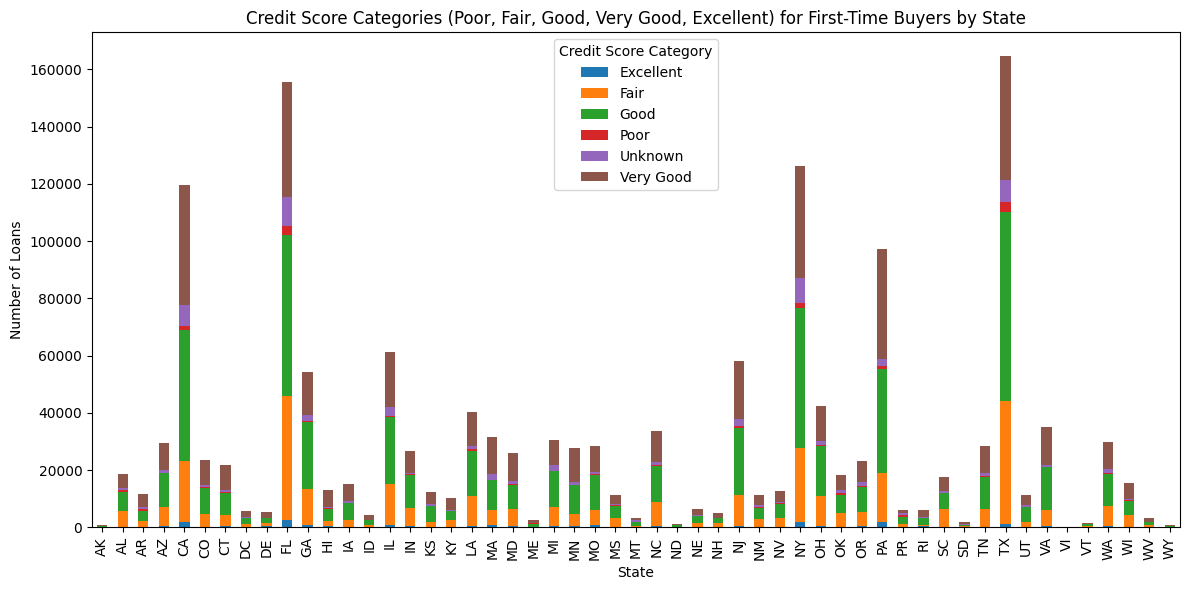

In [ ]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

df_filtered = df_selected.filter(col("First Time Home Buyer Indicator") == "Y")

df_categorized = df_filtered.withColumn(
    "credit_score_category",
    when(col("Borrower Credit Score at Origination") < 580, "Poor")
    .when((col("Borrower Credit Score at Origination") >= 580) & (col("Borrower Credit Score at Origination") < 670), "Fair")
    .when((col("Borrower Credit Score at Origination") >= 670) & (col("Borrower Credit Score at Origination") < 740), "Good")
    .when((col("Borrower Credit Score at Origination") >= 740) & (col("Borrower Credit Score at Origination") < 800), "Very Good")
    .when(col("Borrower Credit Score at Origination") >= 800, "Excellent")
    .otherwise("Unknown")
)

grouped_df = (
    df_categorized
    .groupBy("Property State", "credit_score_category")
    .count()
    .withColumnRenamed("count", "num_loans")
)

pandas_df = grouped_df.toPandas()

pivot_df = pandas_df.pivot(index="Property State", columns="credit_score_category", values="num_loans").fillna(0)

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Credit Score Categories (Poor, Fair, Good, Very Good, Excellent) for First-Time Buyers by State"
)

plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.legend(title="Credit Score Category")
plt.tight_layout()
plt.show()


Analysis 4: I'm going to use `Zero Balance Code` as the loan status column `crt-file-layout-and-glossary_0.xlsx` contains the mapping for its various values.

I'll do the analysis in Spark and then create a heatmap for correlation.

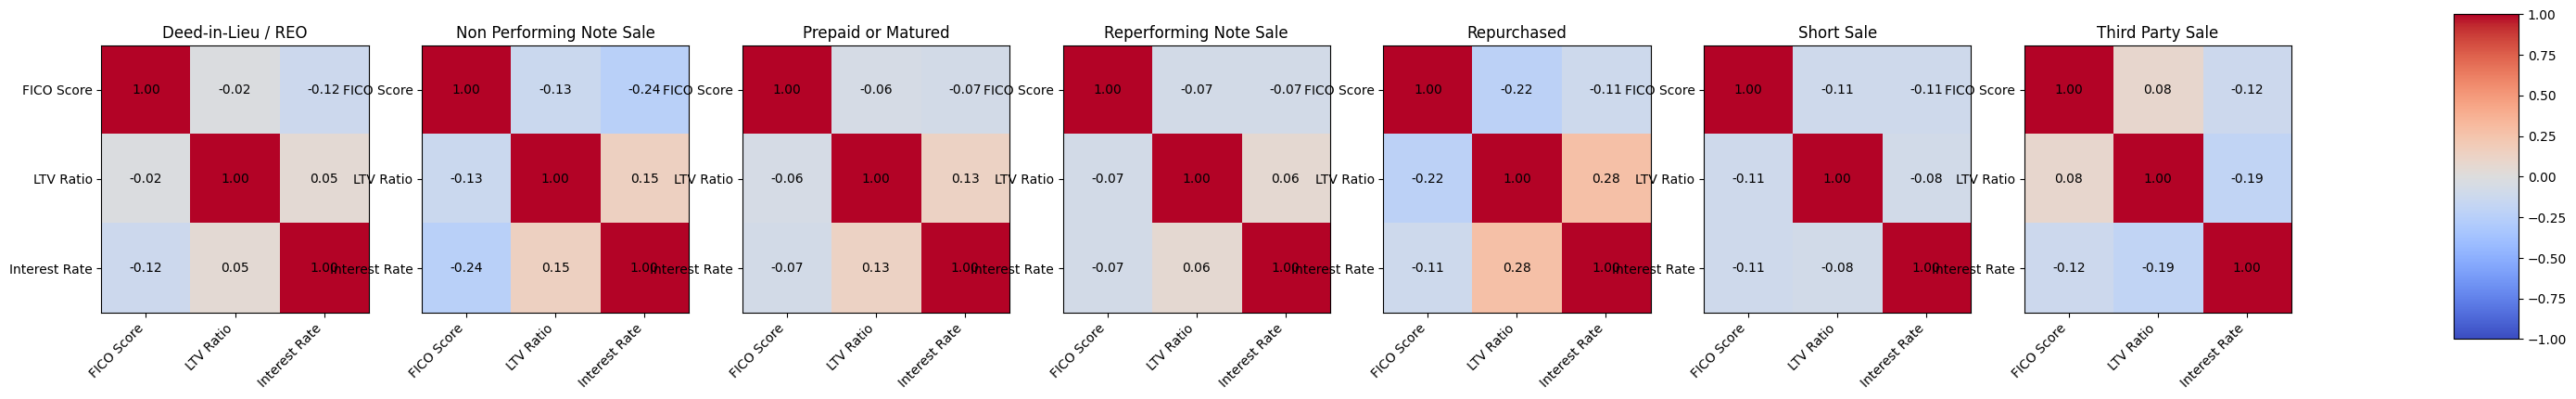

In [ ]:
from pyspark.sql.functions import create_map, lit, col, expr
import matplotlib.pyplot as plt
import numpy as np

def safe_corr(df, c1, c2):
    r = df.stat.corr(c1, c2)
    return r if r is not None else 0

zbc_mapping = create_map(
    [
        lit("1"), lit("Prepaid or Matured"),
        lit("2"), lit("Third Party Sale"),
        lit("3"), lit("Short Sale"),
        lit("6"), lit("Repurchased"),
        lit("9"), lit("Deed-in-Lieu / REO"),
        lit("15"), lit("Non Performing Note Sale"),
        lit("16"), lit("Reperforming Note Sale"),
        lit("96"), lit("Removal")
    ]
)

df_mapped = (
    df_selected.withColumn("zbc_label", zbc_mapping[col("Zero Balance Code")])
      .withColumn("fico_score", col("Borrower Credit Score at Origination").cast("double"))
      .withColumn("ltv_ratio", col("Original Loan to Value Ratio (LTV)").cast("double"))
      .withColumn("interest_rate", col("Original Interest Rate").cast("double"))
)

zbc_labels = (
    df_mapped
    .select("zbc_label")
    .distinct()
    .orderBy("zbc_label")
    .rdd.map(lambda r: r[0])
    .collect()
)
zbc_labels = [x for x in zbc_labels if x is not None]

features = ["fico_score", "ltv_ratio", "interest_rate"]
display_labels = ["FICO Score", "LTV Ratio", "Interest Rate"]

fig, axes = plt.subplots(1, len(zbc_labels), figsize=(5 * len(zbc_labels), 5))
if len(zbc_labels) == 1:
    axes = [axes]

for i, label in enumerate(zbc_labels):
    df_label = df_mapped.filter(df_mapped.zbc_label == label)
    c1 = safe_corr(df_label, "fico_score", "ltv_ratio")
    c2 = safe_corr(df_label, "fico_score", "interest_rate")
    c3 = safe_corr(df_label, "ltv_ratio", "interest_rate")
    cm = np.array([[1, c1, c2],[c1, 1, c3],[c2, c3, 1]])
    ax = axes[i]
    im = ax.imshow(cm, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(label)
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1,2])
    ax.set_xticklabels(display_labels, rotation=45, ha="right")
    ax.set_yticklabels(display_labels)
    for r in range(3):
        for c in range(3):
            ax.text(c, r, f"{cm[r,c]:.2f}", ha="center", va="center", color="black")

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


Analysis 5: this is similar to Analysis 4 but instead of correlations, we need to plot statisical measures for what I'll use a boxplot.

<ipython-input-10-4a4351d09609>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels, showmeans=False)
<ipython-input-10-4a4351d09609>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels, showmeans=False)
<ipython-input-10-4a4351d09609>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels, showmeans=False)


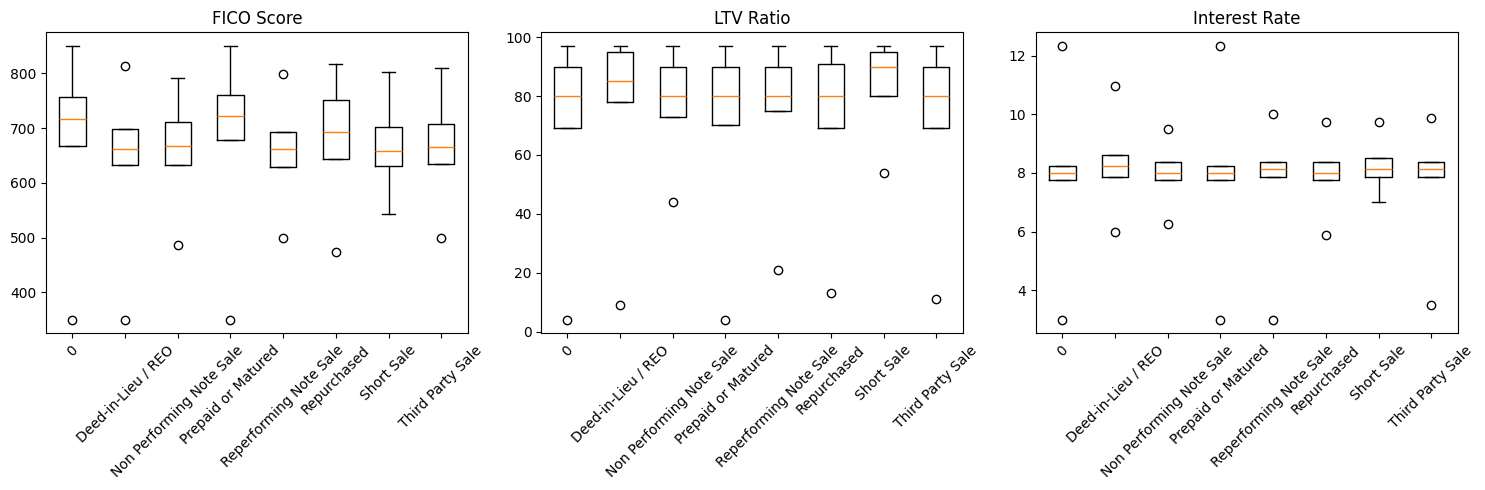

In [ ]:
from pyspark.sql.functions import create_map, lit, col, expr
import matplotlib.pyplot as plt

zbc_mapping = create_map(
    [
        lit("1"), lit("Prepaid or Matured"),
        lit("2"), lit("Third Party Sale"),
        lit("3"), lit("Short Sale"),
        lit("6"), lit("Repurchased"),
        lit("9"), lit("Deed-in-Lieu / REO"),
        lit("15"), lit("Non Performing Note Sale"),
        lit("16"), lit("Reperforming Note Sale"),
        lit("96"), lit("Removal")
    ]
)

df_mapped = (
    df_selected.withColumn("zbc_label", zbc_mapping[col("Zero Balance Code")])
      .withColumn("fico_score", col("Borrower Credit Score at Origination").cast("double"))
      .withColumn("ltv_ratio", col("Original Loan to Value Ratio (LTV)").cast("double"))
      .withColumn("interest_rate", col("Original Interest Rate").cast("double"))
)

quantiles_df = (
    df_mapped.groupBy("zbc_label")
    .agg(
        expr("percentile_approx(fico_score, 0.0, 100) as fico_min"),
        expr("percentile_approx(fico_score, 0.25, 100) as fico_q1"),
        expr("percentile_approx(fico_score, 0.5, 100) as fico_median"),
        expr("percentile_approx(fico_score, 0.75, 100) as fico_q3"),
        expr("percentile_approx(fico_score, 1.0, 100) as fico_max"),

        expr("percentile_approx(ltv_ratio, 0.0, 100) as ltv_min"),
        expr("percentile_approx(ltv_ratio, 0.25, 100) as ltv_q1"),
        expr("percentile_approx(ltv_ratio, 0.5, 100) as ltv_median"),
        expr("percentile_approx(ltv_ratio, 0.75, 100) as ltv_q3"),
        expr("percentile_approx(ltv_ratio, 1.0, 100) as ltv_max"),

        expr("percentile_approx(interest_rate, 0.0, 100) as ir_min"),
        expr("percentile_approx(interest_rate, 0.25, 100) as ir_q1"),
        expr("percentile_approx(interest_rate, 0.5, 100) as ir_median"),
        expr("percentile_approx(interest_rate, 0.75, 100) as ir_q3"),
        expr("percentile_approx(interest_rate, 1.0, 100) as ir_max")
    )
    .orderBy("zbc_label")
)

pdf = quantiles_df.toPandas().fillna(0)
labels = pdf["zbc_label"].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, prefix, title in zip(
    axes,
    ["fico", "ltv", "ir"],
    ["FICO Score", "LTV Ratio", "Interest Rate"]
):
    box_data = []
    for _, row in pdf.iterrows():
        box_data.append([
            row[f"{prefix}_min"],
            row[f"{prefix}_q1"],
            row[f"{prefix}_median"],
            row[f"{prefix}_q3"],
            row[f"{prefix}_max"]
        ])
    ax.boxplot(box_data, labels=labels, showmeans=False)
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Analysis 6:
We have two options for figuring out default risk. We can either use `Current Loan Delinquency Status` (i.e. when the loan has been delinquent for more than 90 days) or `Zero Balance Code` (look at codes 2, 3, 6, 9, 15, and 16) to work out risk. I'm going to go with `Zero Balance Code` because it's simpler and more precise as it just tracks when a loan has left the pool due to default.

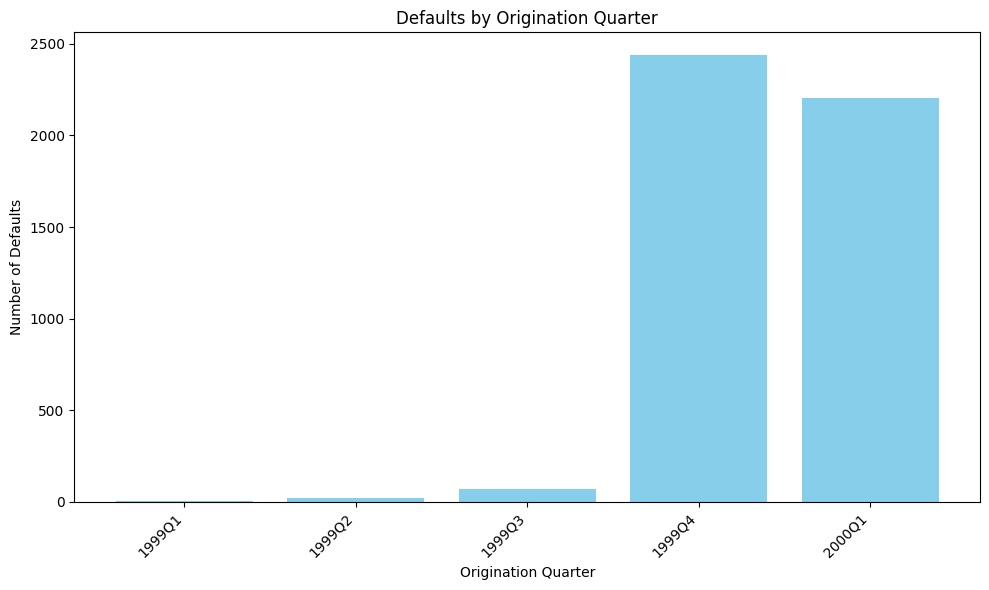

In [ ]:
from pyspark.sql.functions import (
    col, substring, when, count, sum as _sum,
    length, expr
)
import matplotlib.pyplot as plt
import numpy as np

df_default = (
    df_selected
    .withColumn("period_len", length(col("Origination Date")))
    .withColumn(
        "month_str",
        expr("substring(`Origination Date`, 1, period_len - 4)")
    )
    .withColumn("origination_month", col("month_str").cast("int"))
    .withColumn("origination_year", substring(col("Origination Date"), -4, 4).cast("int"))
    .withColumn("origination_quarter", ((col("origination_month") - 1) / 3).cast("int") + 1)
    .drop("period_len", "month_str")
)

df_default = df_default.withColumn(
    "default_flag",
    when(col("Zero Balance Code").isin("2", "3", "6", "9", "15", "16"), 1).otherwise(0)
)

result_default = (
    df_default.groupBy("origination_year", "origination_quarter")
      .agg(_sum("default_flag").alias("total_defaults"))
)

pdf = result_default.toPandas()

pdf["origination_year"] = pdf["origination_year"].fillna(0).astype(int)
pdf["origination_quarter"] = pdf["origination_quarter"].fillna(0).astype(int)

pdf = pdf.sort_values(["origination_year", "origination_quarter"])

pdf["label"] = pdf["origination_year"].astype(str) + "Q" + pdf["origination_quarter"].astype(str)
labels = pdf["label"].tolist()
defaults = pdf["total_defaults"].tolist()


plt.figure(figsize=(10, 6))
plt.bar(labels, defaults, color="skyblue")
plt.xlabel("Origination Quarter")
plt.ylabel("Number of Defaults")
plt.title("Defaults by Origination Quarter")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Analysis 7: This is slightly tricky. We need to work out loan amount recovered and the amount left. The latter is straightforward because we can get it from `UPB at the Time of Removal`. For the former, we'll have to sum up some colums `Credit Enhancement Proceeds`, `Repurchase Make Whole Proceeds`, and `Other Foreclosure Proceeds`. Using other columns is fine too.

Recovery rate is then simply amount_recovered / UPB at the Time of Removal.

In [ ]:
from pyspark.sql.functions import col, when, sum as _sum, avg

df_defaulted = df_selected.withColumn(
    "default_flag",
    when(col("Zero Balance Code").isin("2", "3", "6", "9", "15", "16"), 1).otherwise(0)
)

df_defaulted = df_defaulted.filter(col("default_flag") == 1)

df_recovery = df_defaulted.withColumn(
    "amount_recovered",
    (
        col("Credit Enhancement Proceeds").cast("double")
        + col("Repurchase Make Whole Proceeds").cast("double")
        + col("Other Foreclosure Proceeds").cast("double")
    )
)

df_recovery = df_recovery.withColumn(
    "recovery_rate",
    (col("amount_recovered") / col("UPB at the Time of Removal").cast("double")) * 100
)

result = df_recovery.agg(avg("recovery_rate").alias("avg_recovery_rate"))
result.toPandas()


,avg_recovery_rate
0,19.738153


Analysis 8: `Original List Price` and `Current List Price` are empty in this dataset. We can use `Original UPB` as a proxy instead because it represents the original loan balance.

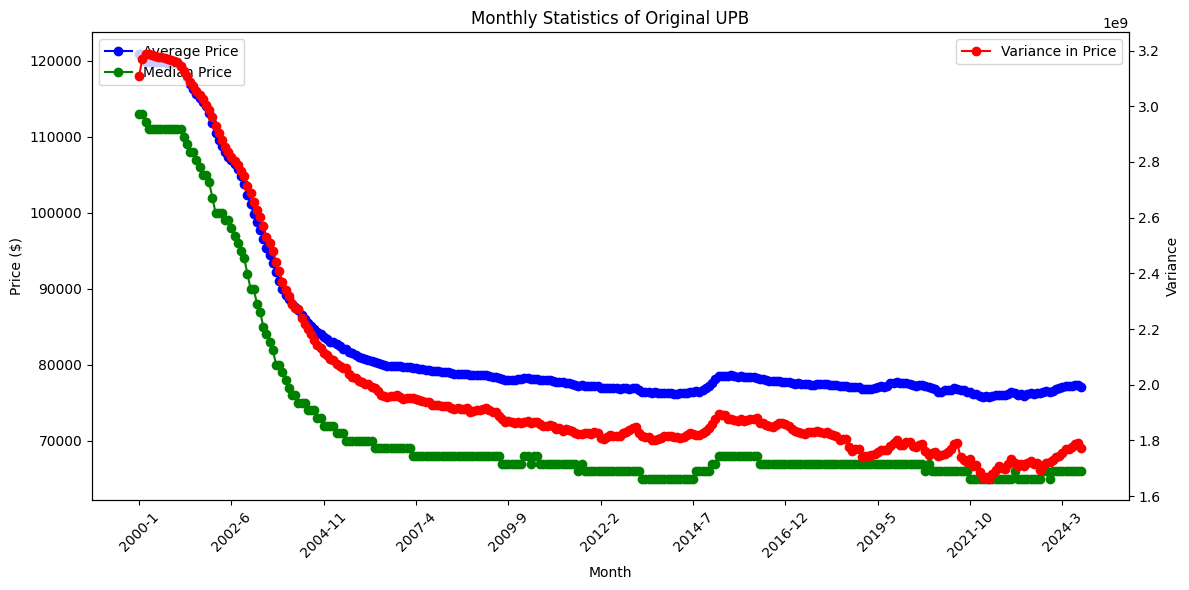

In [ ]:
from pyspark.sql.functions import avg, variance, percentile_approx, expr, substring, length
import matplotlib.pyplot as plt

df_monthly = (
    df_selected
    .withColumn("period_len", length(col("Monthly Reporting Period")))
    .withColumn("month", expr("substring(`Monthly Reporting Period`, 1, period_len - 4)").cast("int"))
    .withColumn("year", substring("Monthly Reporting Period", -4, 4).cast("int"))
    .drop("period_len")
)

monthly_stats = (
    df_monthly.groupBy("year", "month")
    .agg(
        avg("Original UPB").alias("avg_price"),
        percentile_approx("Original UPB", 0.5).alias("median_price"),
        variance("Original UPB").alias("variance_price")
    )
    .orderBy("year", "month")
)

pdf_monthly_stats = monthly_stats.toPandas()
pdf_monthly_stats["period"] = pdf_monthly_stats["year"].astype(str) + "-" + pdf_monthly_stats["month"].astype(str)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["avg_price"],
    label="Average Price", marker="o", color="blue"
)
ax1.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["median_price"],
    label="Median Price", marker="o", color="green"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Price ($)")
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(
    pdf_monthly_stats["period"], pdf_monthly_stats["variance_price"],
    label="Variance in Price", marker="o", color="red"
)
ax2.set_ylabel("Variance")
ax2.legend(loc="upper right")

plt.xticks(range(0, len(pdf_monthly_stats), max(1, len(pdf_monthly_stats)//10)),
           pdf_monthly_stats["period"].iloc[::max(1, len(pdf_monthly_stats)//10)], rotation=45)

plt.title("Monthly Statistics of Original UPB")
plt.tight_layout()
plt.show()


In [ ]:
spark.stop()